# A Toy Model for Finding the "Ionization Fraction"

James Aguirre

First created 30 June 2021

Edited 21 July 2021

The idea here is to take the really simple "MNIST-like" images that show a Gaussian random field with some number pixels above a threshold set to the minimum value to simulate an "ionized region".  So we're adapting Paul's ML bootcamp notebook CNN architecture to regress the single number which is the fraction of pixels that are considered "ionized".

In [1]:
%load_ext tensorboard

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.ndimage as spimg

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

2023-06-08 03:06:54.130839: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
toy_model = np.load('toy_models.npz')
nx, ny, ntrain = toy_model['training_data'].shape

In [5]:
training_data = toy_model['training_data'].T
labels = toy_model['labels']
training_data += toy_model['training_data'].T + 0.*np.random.normal(0, 0.2, size=toy_model['training_data'].T.shape)

In [6]:
training_data.shape

(10000, 32, 32)

In [7]:
example = training_data[10,:,:] #+ 
smex = spimg.gaussian_filter(example, 3)
noise = np.random.normal(0, 0.3, [32,32])
example_answer = labels[10]

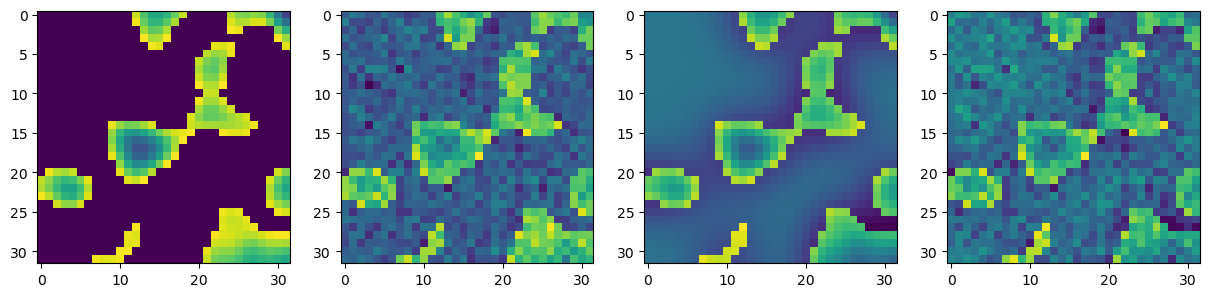

In [8]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(15,6))
ax[0].imshow(example)
ax[1].imshow(example + noise)
ax[2].imshow(example-smex)
ax[3].imshow(example-smex+noise)

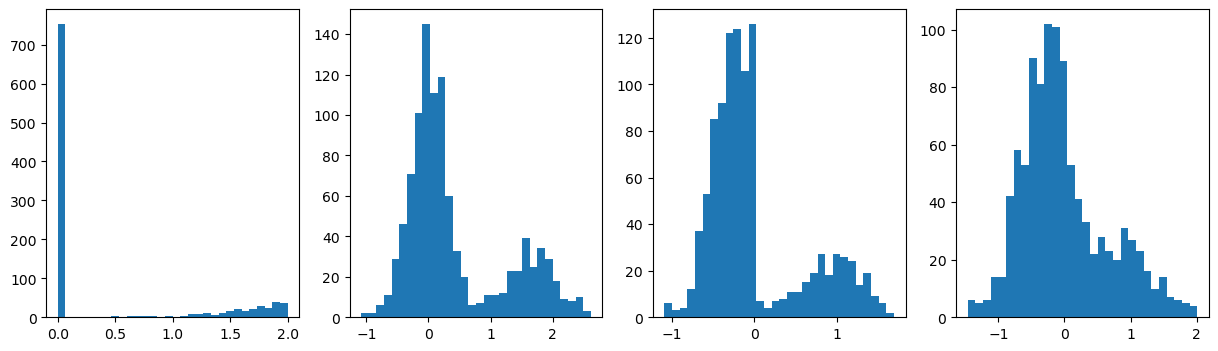

In [9]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(15,4))
ax[0].hist(example.flatten(), bins=30);
ax[1].hist((example+noise).flatten(), bins=30);
ax[2].hist((example-smex).flatten(), bins=30);
ax[3].hist((example-smex+noise).flatten(), bins=30);

In [10]:
# make our model
model = Sequential()

# add layers
model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1))) # was 64
model.add(Conv2D(8, kernel_size=3, activation="relu")) # was 32
model.add(Flatten())
model.add(Dense(1, activation="linear"))

2023-06-08 03:12:06.266829: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
X_train = training_data[0:8000,:,:].reshape(8000,nx,ny,1)
y_train = labels[0:8000]
X_test = training_data[8000:,:,:].reshape(2000,nx,ny,1)
y_test = labels[8000:]

## Visualize the model

In [12]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 8)         1160      
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 1)                 6273      
                                                                 
Total params: 7,593
Trainable params: 7,593
Non-trainable params: 0
_________________________________________________________________
None


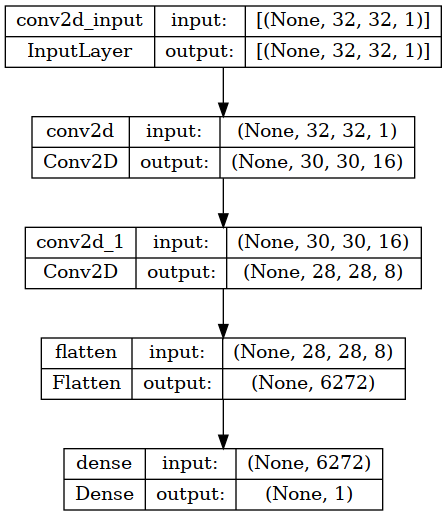

In [13]:
# Need to install pydot for this
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True) #to_file="images/cnn_model_plot.png",

## Compile the Model

In [14]:
model.compile(optimizer="adam", loss="mape")#, metrics=["accuracy"])

## Training the Model
Now it's time to train it!

In [15]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [16]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, callbacks=[tensorboard_callback])

Epoch 1/10
250/250 [==============================] - 33s 127ms/step - loss: 20.9920 - val_loss: 8.5229
Epoch 2/10
250/250 [==============================] - 31s 124ms/step - loss: 7.2601 - val_loss: 6.1453
Epoch 3/10
250/250 [==============================] - 29s 115ms/step - loss: 5.9218 - val_loss: 6.7415
Epoch 4/10
250/250 [==============================] - 29s 115ms/step - loss: 5.2782 - val_loss: 5.2466
Epoch 5/10
250/250 [==============================] - 19s 76ms/step - loss: 4.8933 - val_loss: 6.2897
Epoch 6/10
250/250 [==============================] - 29s 118ms/step - loss: 4.5757 - val_loss: 4.4900
Epoch 7/10
250/250 [==============================] - 41s 163ms/step - loss: 4.3015 - val_loss: 4.5203
Epoch 8/10
250/250 [==============================] - 27s 107ms/step - loss: 4.1150 - val_loss: 5.7572
Epoch 9/10
250/250 [==============================] - 19s 75ms/step - loss: 3.9261 - val_loss: 5.0410
Epoch 10/10
250/250 [==============================] - 15s 58ms/step - los

Visualize https://www.tensorflow.org/tensorboard/get_started

In [17]:
import os
os.environ['TENSORBOARD_BINARY'] = '/home/jaguirre/anaconda3/envs/ml/bin/tensorboard'
# This does seem to work ...
%tensorboard --logdir logs/fit

In [18]:
predictions_validation = model.predict(X_test).squeeze()
predictions_training = model.predict(X_train).squeeze()

250/250 [==============================] - 4s 18ms/step


In [19]:
def VisualizeTrainingValidation(true_train, pred_train, true_val, pred_val, 
                                xmin = None, ymin = None, xmax = None, ymax = None):

    if xmin is None:
        xmin = np.append(true_train, true_val).min()
    if xmax is None:
        xmax = np.append(true_train, true_val).max()
    if ymin is None:
        ymin = np.append(pred_train, pred_val).min()
    if ymax is None:
        ymax = np.append(pred_train, pred_val).max()
    

    fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12,7))
    # -----
    ax[0,0].plot(true_train, pred_train, '.')
    ax[0,0].plot([xmin, xmax], [0,1])
    ax[0,0].set_title('Training')
    ax[0,0].set_ylabel('Prediction')
    ax[0,1].plot(true_val, pred_val, '.')
    ax[0,1].plot([0,1], [0,1])
    ax[0,1].set_title('Validation')
    # -----
    ax[1,0].plot(true_train, pred_train - true_train, '.', label='{:.4f}'.format(np.std(pred_train - true_train)))
    ax[1,0].axhline(0, color='orange')
    ax[1,0].legend()
    ax[1,0].set_ylabel('Absolute error')
    ax[1,1].plot(true_val, pred_val - true_val, '.', label='{:.4f}'.format(np.std(pred_val - true_val)))
    ax[1,1].axhline(0, color='orange')
    ax[1,1].legend()
    
    # -----
    ax[2,0].plot(true_train, (pred_train - true_train)/true_train, '.')
    ax[2,0].axhline(0, color='orange')
    ax[2,0].set_ylabel('Fractional Error')
    ax[2,0].set_xlabel('True Value')
    ax[2,0].set_ylim(-1,1)
    ax[2,1].plot(true_val, (pred_val - true_val)/true_val, '.')
    ax[2,1].axhline(0, color='orange')
    ax[2,1].set_xlabel('True Value')
    ax[2,1].set_ylim(-1,1)


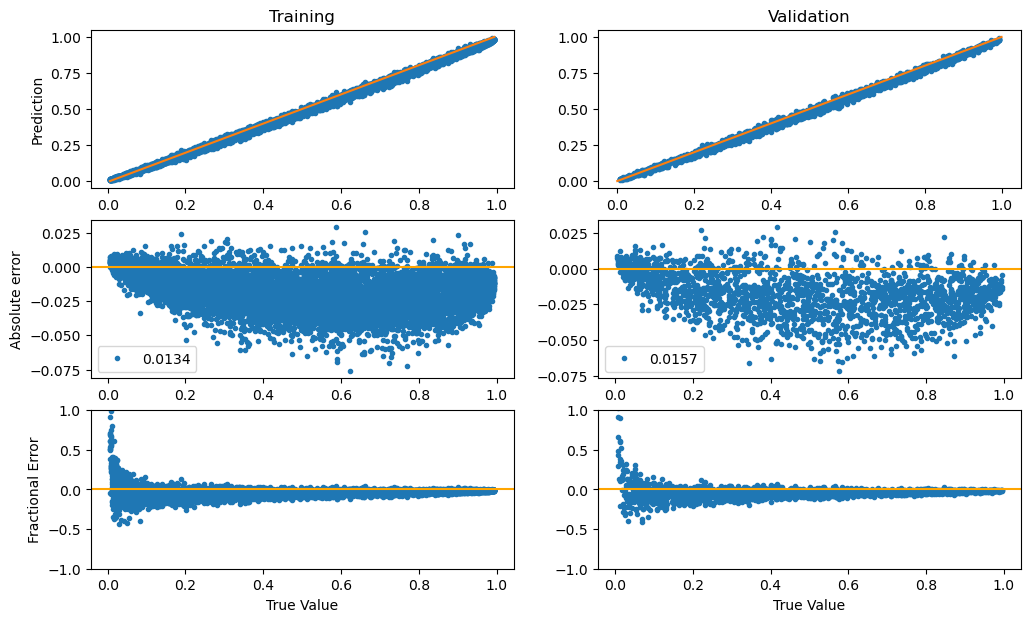

In [20]:
VisualizeTrainingValidation(y_train, predictions_training, y_test, predictions_validation)

In [21]:
y_train.shape, predictions_training.shape, y_test.shape, predictions_validation.shape

((8000,), (8000,), (2000,), (2000,))

To make use of TensorBoard, we add what's known as a `callback` to Keras's `fit` method on a Model object. Then from the command line, we open up TensorBoard and can visualize what's going on.

## Using TensorBoard
While that is running, open up a terminal, and navigate to the directory where these notebooks are. You should see a directory called `logs`. For example:
```bash
$ ls
Installation.ipynb  Lesson2.ipynb  Lesson4.ipynb  data    logs
Lesson1.ipynb       Lesson3.ipynb  Lesson5.ipynb  images

$ tensorboard --logdir=./logs
```
This will open up the TensorBoard program, which will give you access to quantities like the accuracy and loss values as a function of training epoch, as well as a visualization of the TensorFlow graph that's been generated by the model. There are a lot of nice features that TensorBoard has in it, so take a look!

In [22]:
ls logs/fit

20230608-025455/  20230608-031219/
